In [18]:
import rclpy
from rclpy.serialization import deserialize_message
from rosbag2_py import SequentialReader, StorageOptions, ConverterOptions
from builtin_interfaces.msg import Time
import pandas as pd

def ros_time_to_seconds(ros_time):
    """Convert ROS 2 Time to seconds."""
    return ros_time.sec + ros_time.nanosec * 1e-9

def extract_topic_data(bag_path, topic_name, msg_type):
    """
    Extracts data from a specific topic in a ROS 2 bag file.
    
    Args:
        bag_path (str): Path to the ROS 2 bag file.
        topic_name (str): Topic to extract data from.
        msg_type: Message type class (e.g., `sensor_msgs.msg.Imu`).
    
    Returns:
        pd.DataFrame: DataFrame containing timestamps and relevant topic data.
    """
    # Initialize ROS 2 bag reader
    storage_options = StorageOptions(uri=bag_path, storage_id="sqlite3")
    converter_options = ConverterOptions(
        input_serialization_format="cdr", output_serialization_format="cdr"
    )
    reader = SequentialReader()
    reader.open(storage_options, converter_options)

    # Initialize lists to store timestamps and data
    timestamps = []
    data_dict = {}

    # Read messages from the bag
    while reader.has_next():
        topic, data, timestamp = reader.read_next()
        if topic == topic_name:
            # Deserialize the message
            msg = deserialize_message(data, msg_type)
            
            # Convert ROS time to seconds
            ros_time = Time(sec=timestamp // 10**9, nanosec=timestamp % 10**9)
            timestamps.append(ros_time_to_seconds(ros_time))
            
            # Extract all fields from the message dynamically
            for field_name in msg.__slots__:
                if field_name not in data_dict:
                    data_dict[field_name] = []
                data_dict[field_name].append(getattr(msg, field_name))

    # Create a DataFrame
    df = pd.DataFrame(data_dict)
    df.insert(0, "timestamp", timestamps)  # Add timestamps as the first column
    return df


[INFO] [1733935401.364866222] [rosbag2_storage]: Opened database 'test/test_0.db3' for READ_ONLY.
[INFO] [1733935404.927917508] [rosbag2_storage]: Opened database 'test/test_0.db3' for READ_ONLY.


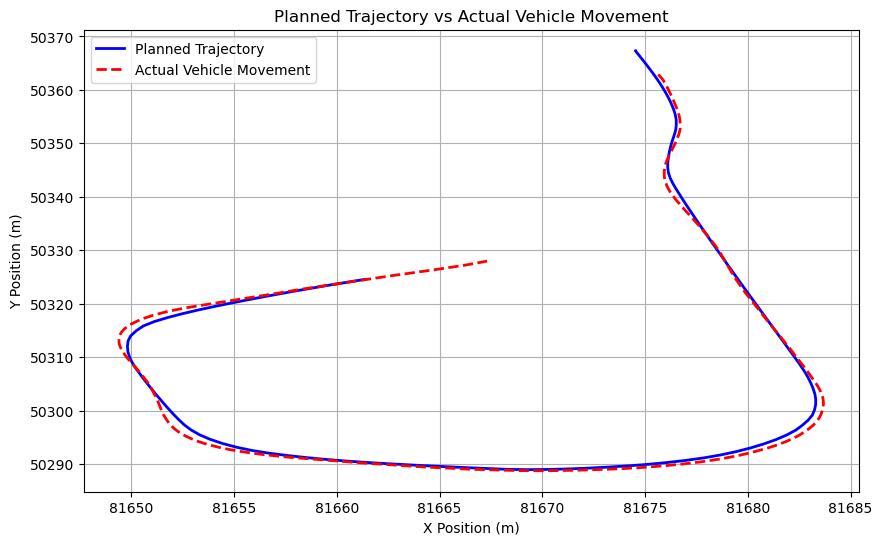

In [19]:
import matplotlib.pyplot as plt

# Assuming `extract_topic_data` is a function to extract data from ROS2 bags
from autoware_planning_msgs.msg import Trajectory
from nav_msgs.msg import Odometry

# Path to your bag file
bag_file_path = "test/test_0.db3"

# Extract trajectory points
trajectory_topic = "/planning/scenario_planning/scenario_selector/trajectory"
trajectory_data = extract_topic_data(bag_file_path, trajectory_topic, Trajectory)

# Extract vehicle position points
odometry_topic = "/localization/kinematic_state"
odometry_data = extract_topic_data(bag_file_path, odometry_topic, Odometry)

# Extract X and Y for trajectory (first point at each timestamp)
trajectory_x = [point[0].pose.position.x for point in trajectory_data["_points"]]
trajectory_y = [point[0].pose.position.y for point in trajectory_data["_points"]]

# Extract X and Y for vehicle movement
odometry_x = [pose.pose.position.x for pose in odometry_data["_pose"]]
odometry_y = [pose.pose.position.y for pose in odometry_data["_pose"]]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(trajectory_x, trajectory_y, label="Planned Trajectory", color="blue", linewidth=2)
plt.plot(odometry_x, odometry_y, label="Actual Vehicle Movement", color="red", linestyle="--", linewidth=2)
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("Planned Trajectory vs Actual Vehicle Movement")
plt.legend()
plt.grid(True)
plt.show()


[INFO] [1733935406.343138060] [rosbag2_storage]: Opened database 'test/test_0.db3' for READ_ONLY.


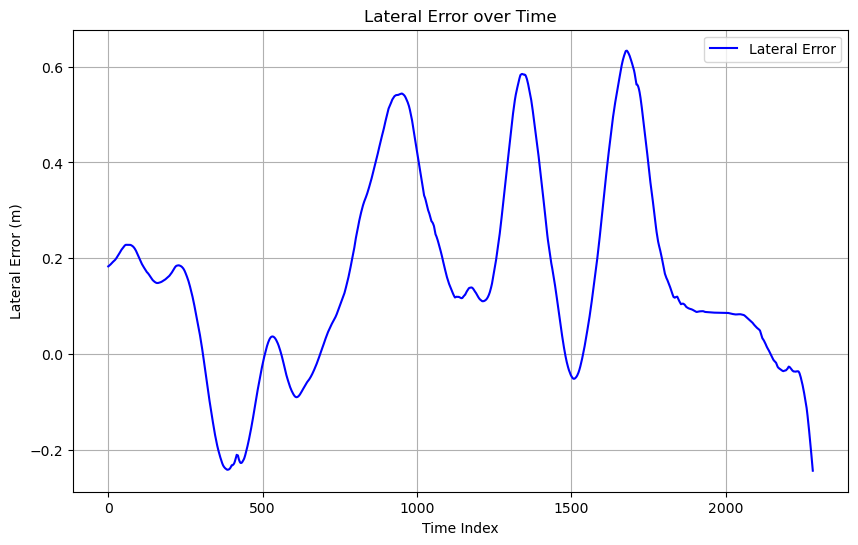

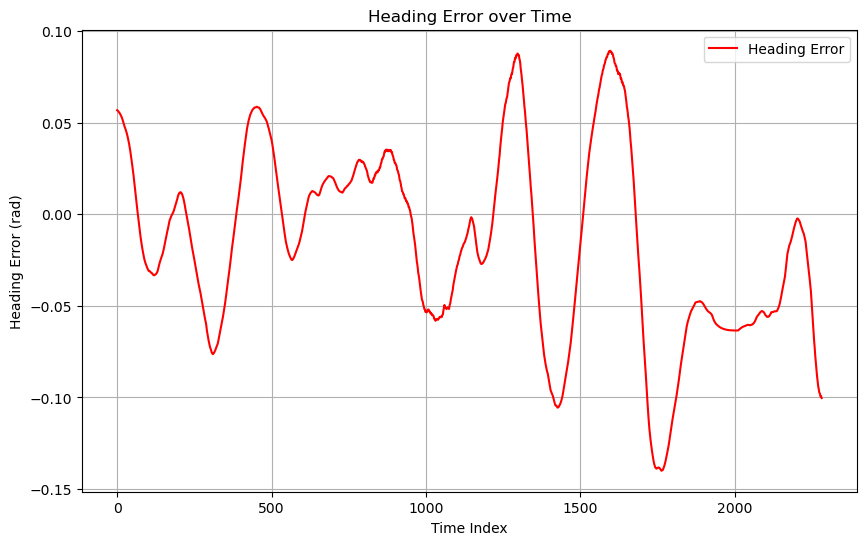

In [20]:
from control_performance_analysis.msg import ErrorStamped

# Path to your bag file
bag_file_path = "test/test_0.db3"

# Topic to extract
topic = "/control_performance/performance_vars"

# Extract data
performance_data = extract_topic_data(bag_file_path, topic, ErrorStamped)

# Extract lateral error and heading error
lateral_error = [error.lateral_error for error in performance_data["_error"]]
heading_error = [error.heading_error for error in performance_data["_error"]]

# Create time indices (or use timestamps if available)
time_indices = range(len(lateral_error))

# Plot Lateral Error
plt.figure(figsize=(10, 6))
plt.plot(time_indices, lateral_error, label="Lateral Error", color="blue")
plt.xlabel("Time Index")
plt.ylabel("Lateral Error (m)")
plt.title("Lateral Error over Time")
plt.grid(True)
plt.legend()
plt.show()

# Plot Heading Error
plt.figure(figsize=(10, 6))
plt.plot(time_indices, heading_error, label="Heading Error", color="red")
plt.xlabel("Time Index")
plt.ylabel("Heading Error (rad)")
plt.title("Heading Error over Time")
plt.grid(True)
plt.legend()
plt.show()


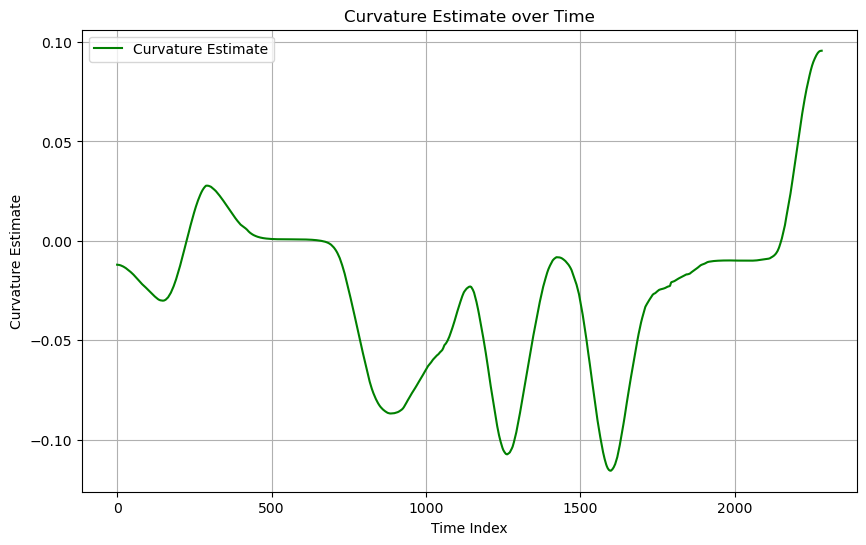

In [21]:
curvature_estimate = [error.curvature_estimate for error in performance_data["_error"]]

# Create time indices (or use timestamps if available)
time_indices = range(len(curvature_estimate))

# Plot Curvature Estimate
plt.figure(figsize=(10, 6))
plt.plot(time_indices, curvature_estimate, label="Curvature Estimate", color="green")
plt.xlabel("Time Index")
plt.ylabel("Curvature Estimate")
plt.title("Curvature Estimate over Time")
plt.grid(True)
plt.legend()
plt.show()

[INFO] [1733936152.588806858] [rosbag2_storage]: Opened database 'test/test_0.db3' for READ_ONLY.
[INFO] [1733936153.665150891] [rosbag2_storage]: Opened database 'test/test_0.db3' for READ_ONLY.
[INFO] [1733936156.665964893] [rosbag2_storage]: Opened database 'test/test_0.db3' for READ_ONLY.


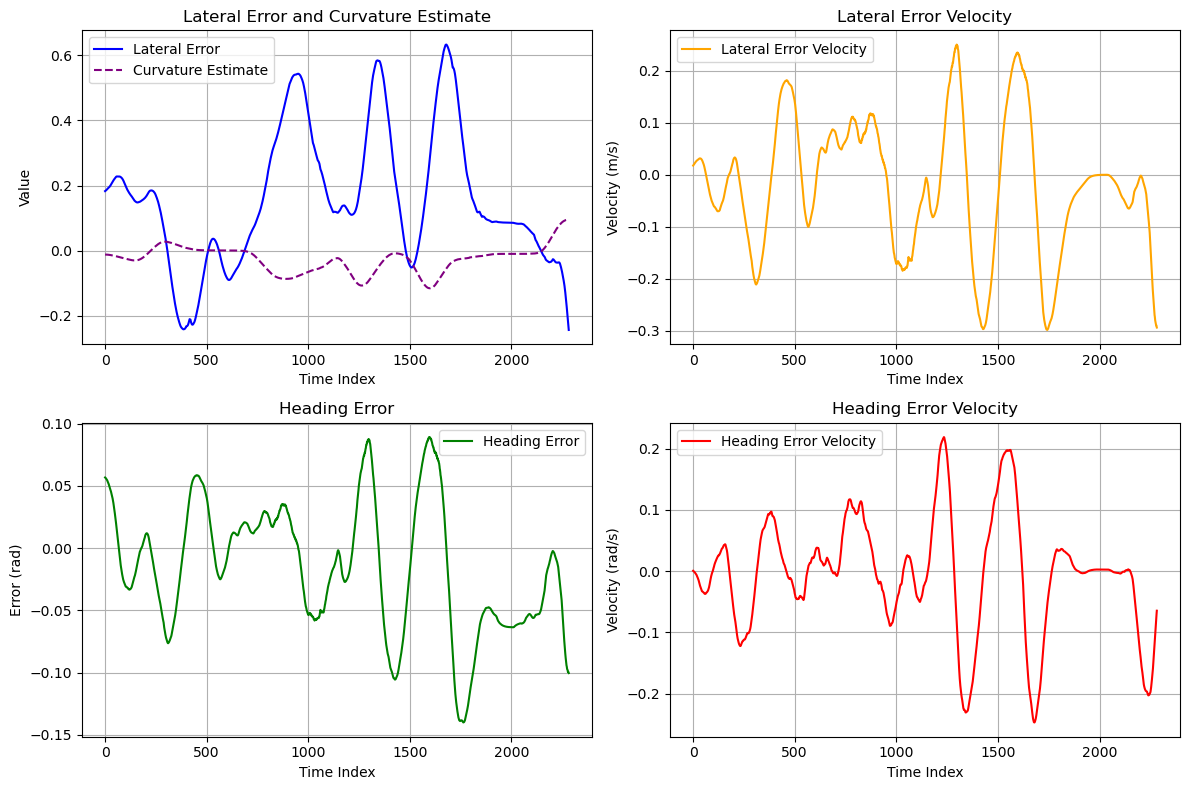

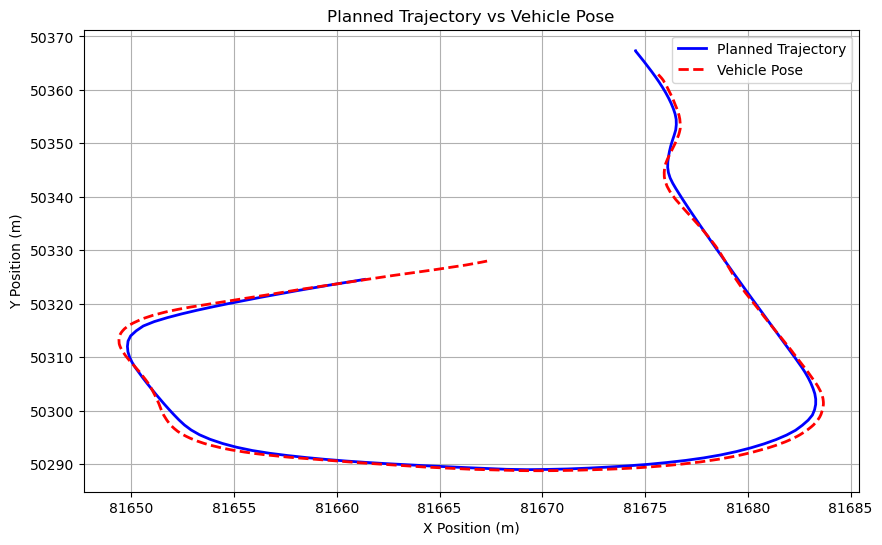

In [22]:
import matplotlib.pyplot as plt
from control_performance_analysis.msg import ErrorStamped
from autoware_planning_msgs.msg import Trajectory
from nav_msgs.msg import Odometry

# Path to your bag file
bag_file_path = "test/test_0.db3"

# Topics to extract
error_topic = "/control_performance/performance_vars"
trajectory_topic = "/planning/scenario_planning/scenario_selector/trajectory"
odometry_topic = "/localization/kinematic_state"

# Extract data
error_data = extract_topic_data(bag_file_path, error_topic, ErrorStamped)
trajectory_data = extract_topic_data(bag_file_path, trajectory_topic, Trajectory)
odometry_data = extract_topic_data(bag_file_path, odometry_topic, Odometry)

# Extract fields for subplots
lateral_error = [error.lateral_error for error in error_data["_error"]]
curvature_estimate = [error.curvature_estimate for error in error_data["_error"]]
lateral_error_velocity = [error.lateral_error_velocity for error in error_data["_error"]]
heading_error = [error.heading_error for error in error_data["_error"]]
heading_error_velocity = [error.heading_error_velocity for error in error_data["_error"]]

# Extract trajectory and vehicle positions
trajectory_x = [point[0].pose.position.x for point in trajectory_data["_points"]]
trajectory_y = [point[0].pose.position.y for point in trajectory_data["_points"]]
vehicle_x = [pose.pose.position.x for pose in odometry_data["_pose"]]
vehicle_y = [pose.pose.position.y for pose in odometry_data["_pose"]]

# Plotting Subplots
plt.figure(figsize=(12, 8))

# Lateral Error and Curvature Estimate
plt.subplot(2, 2, 1)
plt.plot(lateral_error, label="Lateral Error", color="blue")
plt.plot(curvature_estimate, label="Curvature Estimate", color="purple", linestyle="--")
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.title("Lateral Error and Curvature Estimate")
plt.grid(True)
plt.legend()

# Lateral Error Velocity
plt.subplot(2, 2, 2)
plt.plot(lateral_error_velocity, label="Lateral Error Velocity", color="orange")
plt.xlabel("Time Index")
plt.ylabel("Velocity (m/s)")
plt.title("Lateral Error Velocity")
plt.grid(True)
plt.legend()

# Heading Error
plt.subplot(2, 2, 3)
plt.plot(heading_error, label="Heading Error", color="green")
plt.xlabel("Time Index")
plt.ylabel("Error (rad)")
plt.title("Heading Error")
plt.grid(True)
plt.legend()

# Heading Error Velocity
plt.subplot(2, 2, 4)
plt.plot(heading_error_velocity, label="Heading Error Velocity", color="red")
plt.xlabel("Time Index")
plt.ylabel("Velocity (rad/s)")
plt.title("Heading Error Velocity")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Plotting X vs Y (Trajectory and Vehicle Pose)
plt.figure(figsize=(10, 6))
plt.plot(trajectory_x, trajectory_y, label="Planned Trajectory", color="blue", linewidth=2)
plt.plot(vehicle_x, vehicle_y, label="Vehicle Pose", color="red", linestyle="--", linewidth=2)
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("Planned Trajectory vs Vehicle Pose")
plt.legend()
plt.grid(True)
plt.show()


[INFO] [1733938316.842763491] [rosbag2_storage]: Opened database 'nonlinear/nonlinear/nonlinear_0.db3' for READ_ONLY.
[INFO] [1733938318.002679757] [rosbag2_storage]: Opened database 'nonlinear/nonlinear/nonlinear_0.db3' for READ_ONLY.
[INFO] [1733938320.977633878] [rosbag2_storage]: Opened database 'nonlinear/nonlinear/nonlinear_0.db3' for READ_ONLY.
[INFO] [1733938322.213391209] [rosbag2_storage]: Opened database 'linear/linear/linear_0.db3' for READ_ONLY.
[INFO] [1733938323.379950026] [rosbag2_storage]: Opened database 'linear/linear/linear_0.db3' for READ_ONLY.
[INFO] [1733938326.066893456] [rosbag2_storage]: Opened database 'linear/linear/linear_0.db3' for READ_ONLY.


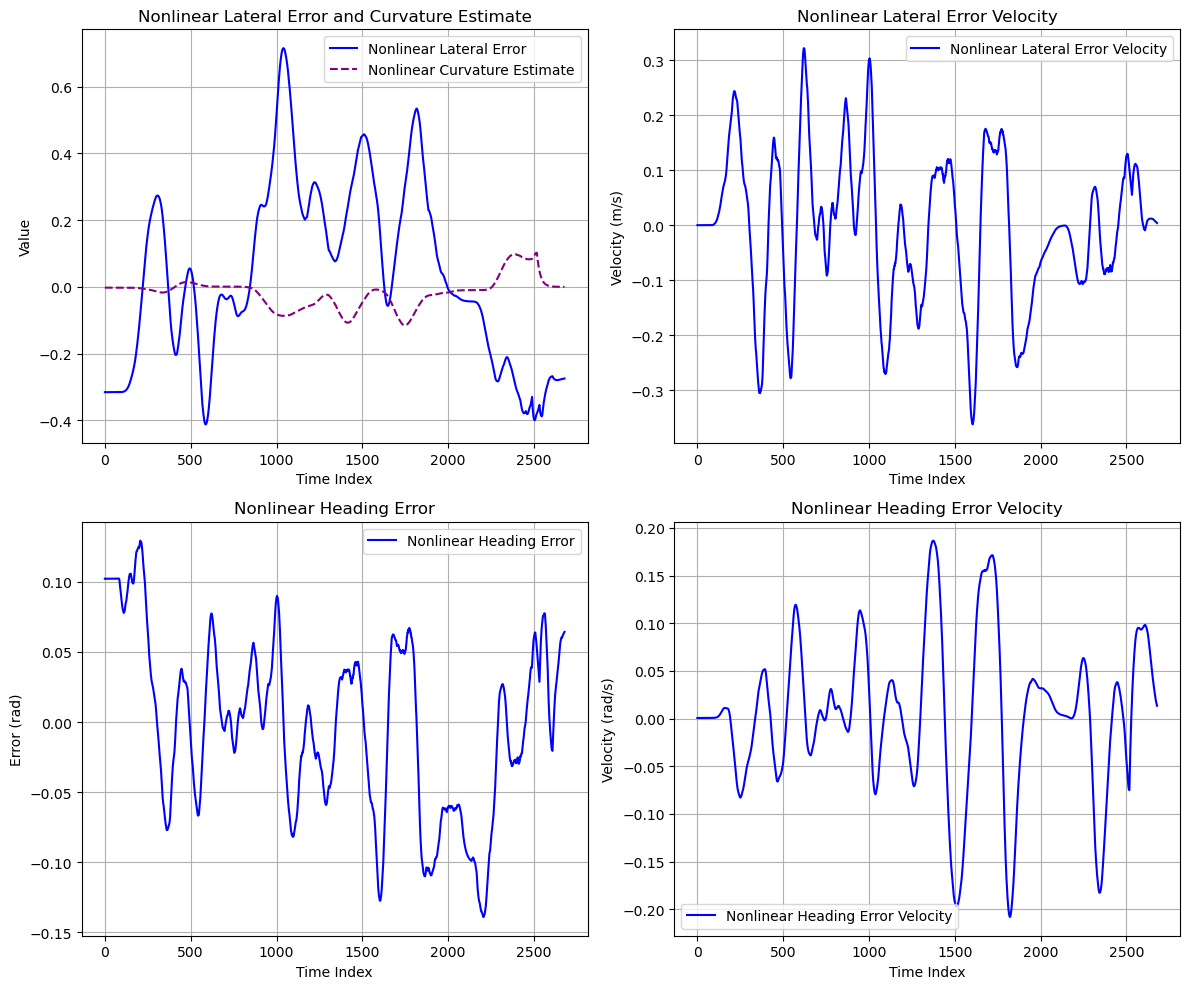

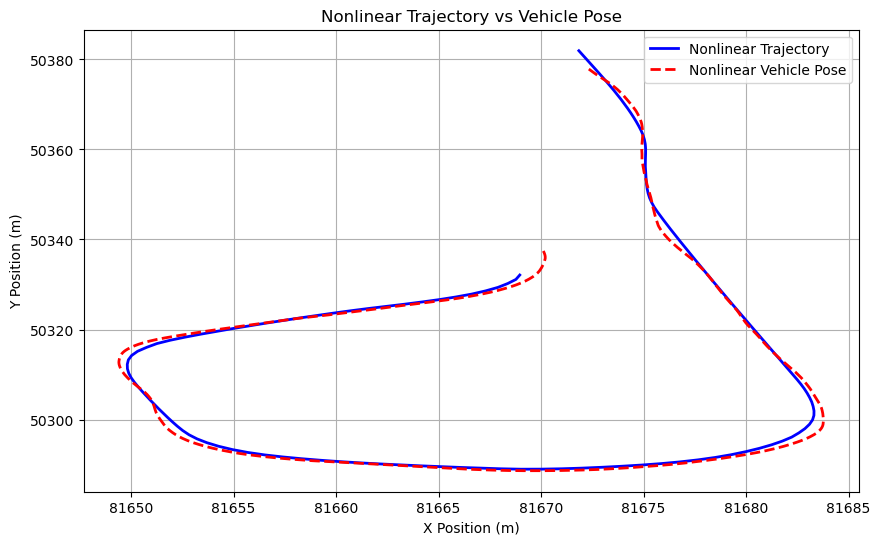

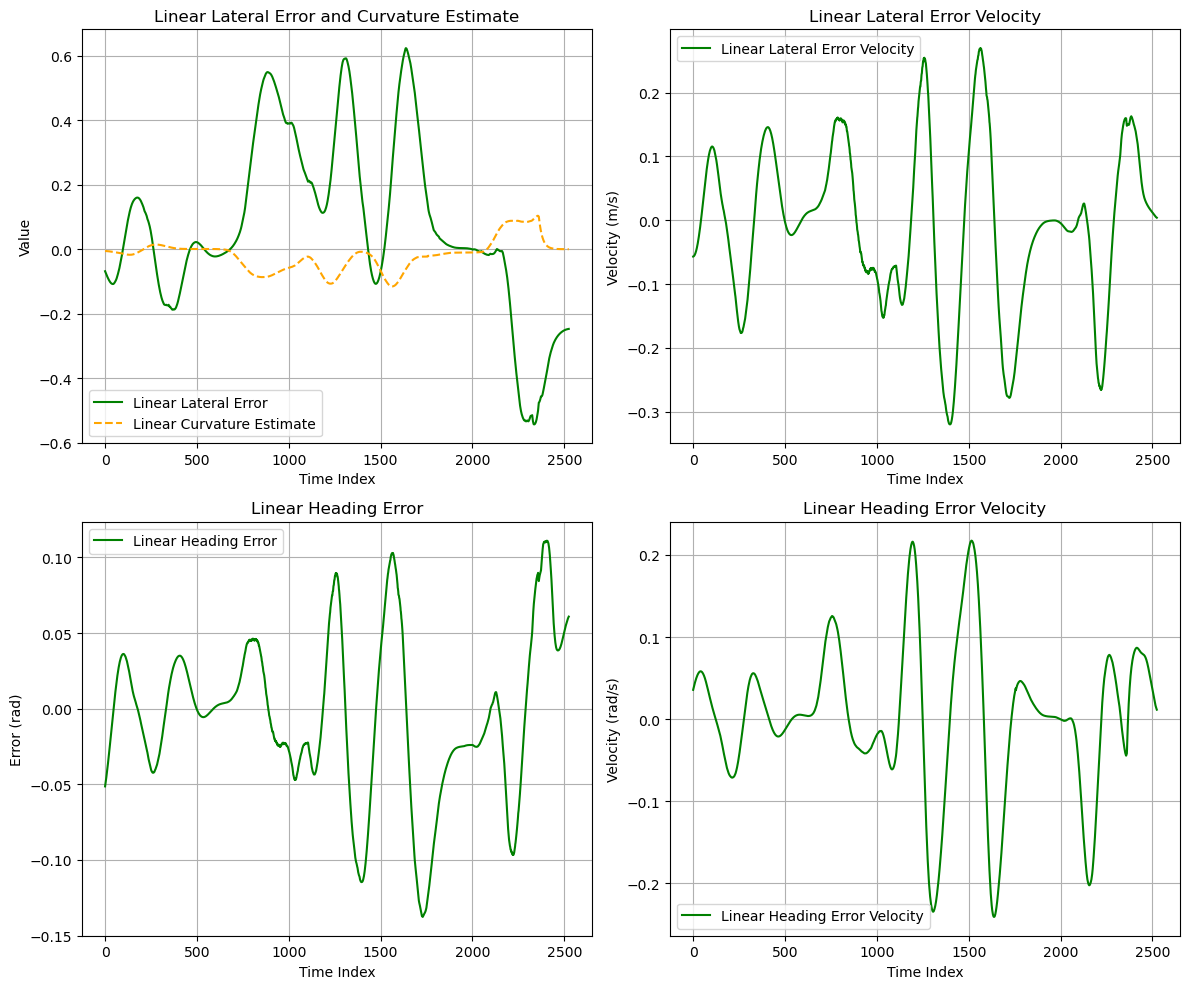

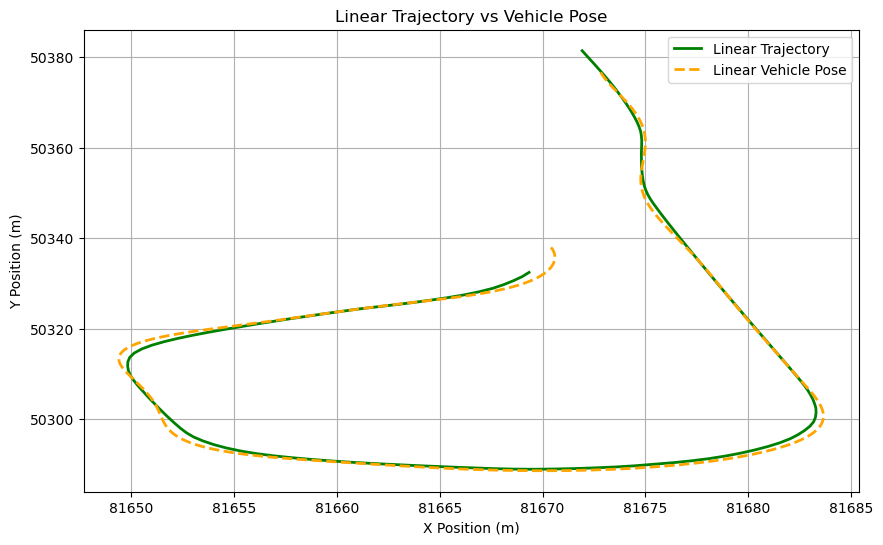

In [32]:
import matplotlib.pyplot as plt
from control_performance_analysis.msg import ErrorStamped
from autoware_planning_msgs.msg import Trajectory
from nav_msgs.msg import Odometry

# File paths
nonlinear_bag = "nonlinear/nonlinear/nonlinear_0.db3"
linear_bag = "linear/linear/linear_0.db3"

# Topic names
error_topic = "/control_performance/performance_vars"
trajectory_topic = "/planning/scenario_planning/scenario_selector/trajectory"
odometry_topic = "/localization/kinematic_state"

# Extract nonlinear data
nonlinear_error = extract_topic_data(nonlinear_bag, error_topic, ErrorStamped)
nonlinear_trajectory = extract_topic_data(nonlinear_bag, trajectory_topic, Trajectory)
nonlinear_odometry = extract_topic_data(nonlinear_bag, odometry_topic, Odometry)

# Extract linear data
linear_error = extract_topic_data(linear_bag, error_topic, ErrorStamped)
linear_trajectory = extract_topic_data(linear_bag, trajectory_topic, Trajectory)
linear_odometry = extract_topic_data(linear_bag, odometry_topic, Odometry)

# Extract metrics for nonlinear data
nonlinear_lateral_error = [error.lateral_error for error in nonlinear_error["_error"]]
nonlinear_curvature_estimate = [error.curvature_estimate for error in nonlinear_error["_error"]]
nonlinear_lateral_error_velocity = [error.lateral_error_velocity for error in nonlinear_error["_error"]]
nonlinear_heading_error = [error.heading_error for error in nonlinear_error["_error"]]
nonlinear_heading_error_velocity = [error.heading_error_velocity for error in nonlinear_error["_error"]]
nonlinear_trajectory_x = [point[0].pose.position.x for point in nonlinear_trajectory["_points"]]
nonlinear_trajectory_y = [point[0].pose.position.y for point in nonlinear_trajectory["_points"]]
nonlinear_vehicle_x = [pose.pose.position.x for pose in nonlinear_odometry["_pose"]]
nonlinear_vehicle_y = [pose.pose.position.y for pose in nonlinear_odometry["_pose"]]

# Extract metrics for linear data
linear_lateral_error = [error.lateral_error for error in linear_error["_error"]]
linear_curvature_estimate = [error.curvature_estimate for error in linear_error["_error"]]
linear_lateral_error_velocity = [error.lateral_error_velocity for error in linear_error["_error"]]
linear_heading_error = [error.heading_error for error in linear_error["_error"]]
linear_heading_error_velocity = [error.heading_error_velocity for error in linear_error["_error"]]
linear_trajectory_x = [point[0].pose.position.x for point in linear_trajectory["_points"]]
linear_trajectory_y = [point[0].pose.position.y for point in linear_trajectory["_points"]]
linear_vehicle_x = [pose.pose.position.x for pose in linear_odometry["_pose"]]
linear_vehicle_y = [pose.pose.position.y for pose in linear_odometry["_pose"]]

# Plotting Nonlinear Data
plt.figure(figsize=(12, 10))

# Lateral Error and Curvature Estimate
plt.subplot(2, 2, 1)
plt.plot(nonlinear_lateral_error, label="Nonlinear Lateral Error", color="blue")
plt.plot(nonlinear_curvature_estimate, label="Nonlinear Curvature Estimate", color="purple", linestyle="--")
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.title("Nonlinear Lateral Error and Curvature Estimate")
plt.grid(True)
plt.legend()

# Lateral Error Velocity
plt.subplot(2, 2, 2)
plt.plot(nonlinear_lateral_error_velocity, label="Nonlinear Lateral Error Velocity", color="blue")
plt.xlabel("Time Index")
plt.ylabel("Velocity (m/s)")
plt.title("Nonlinear Lateral Error Velocity")
plt.grid(True)
plt.legend()

# Heading Error
plt.subplot(2, 2, 3)
plt.plot(nonlinear_heading_error, label="Nonlinear Heading Error", color="blue")
plt.xlabel("Time Index")
plt.ylabel("Error (rad)")
plt.title("Nonlinear Heading Error")
plt.grid(True)
plt.legend()

# Heading Error Velocity
plt.subplot(2, 2, 4)
plt.plot(nonlinear_heading_error_velocity, label="Nonlinear Heading Error Velocity", color="blue")
plt.xlabel("Time Index")
plt.ylabel("Velocity (rad/s)")
plt.title("Nonlinear Heading Error Velocity")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Plotting Nonlinear X vs Y (Trajectory and Vehicle Pose)
plt.figure(figsize=(10, 6))
plt.plot(nonlinear_trajectory_x, nonlinear_trajectory_y, label="Nonlinear Trajectory", color="blue", linewidth=2)
plt.plot(nonlinear_vehicle_x, nonlinear_vehicle_y, label="Nonlinear Vehicle Pose", color="red", linestyle="--", linewidth=2)
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("Nonlinear Trajectory vs Vehicle Pose")
plt.legend()
plt.grid(True)
plt.show()

# Plotting Linear Data
plt.figure(figsize=(12, 10))

# Lateral Error and Curvature Estimate
plt.subplot(2, 2, 1)
plt.plot(linear_lateral_error, label="Linear Lateral Error", color="green")
plt.plot(linear_curvature_estimate, label="Linear Curvature Estimate", color="orange", linestyle="--")
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.title("Linear Lateral Error and Curvature Estimate")
plt.grid(True)
plt.legend()

# Lateral Error Velocity
plt.subplot(2, 2, 2)
plt.plot(linear_lateral_error_velocity, label="Linear Lateral Error Velocity", color="green")
plt.xlabel("Time Index")
plt.ylabel("Velocity (m/s)")
plt.title("Linear Lateral Error Velocity")
plt.grid(True)
plt.legend()

# Heading Error
plt.subplot(2, 2, 3)
plt.plot(linear_heading_error, label="Linear Heading Error", color="green")
plt.xlabel("Time Index")
plt.ylabel("Error (rad)")
plt.title("Linear Heading Error")
plt.grid(True)
plt.legend()

# Heading Error Velocity
plt.subplot(2, 2, 4)
plt.plot(linear_heading_error_velocity, label="Linear Heading Error Velocity", color="green")
plt.xlabel("Time Index")
plt.ylabel("Velocity (rad/s)")
plt.title("Linear Heading Error Velocity")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Plotting Linear X vs Y (Trajectory and Vehicle Pose)
plt.figure(figsize=(10, 6))
plt.plot(linear_trajectory_x, linear_trajectory_y, label="Linear Trajectory", color="green", linewidth=2)
plt.plot(linear_vehicle_x, linear_vehicle_y, label="Linear Vehicle Pose", color="orange", linestyle="--", linewidth=2)
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("Linear Trajectory vs Vehicle Pose")
plt.legend()
plt.grid(True)
plt.show()
